In [1]:
import adlfs
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import rioxarray

The following Snow and Ice products are available in Azure Blob Storage:

- Storage Account: `goeseuwest`
- Storage Containers:
  - `noaa-goes16`
  - `noaa-goes17`
  - `noaa-goes18`
- Products:
  - Snow Cover:
    - ABI-L2-FSCC (CONUS)
    - ABI-L2-FSCF (Full Disk)
    - ABI-L2-FSCM (Mesoscale)
  - Ice Concentration:
      - ABI-L2-AICEF (Full Disk)
  - Ice Thickness:
      - ABI-L2-AITAF (Full Disk)

We can use `adlfs` to list files, get properties about a specific file, etc.

In [2]:
fs = adlfs.AzureBlobFileSystem("goeseuwest")

In [3]:
files = fs.ls("noaa-goes16/ABI-L2-FSCC/2023/330/17")
files[0]

'noaa-goes16/ABI-L2-FSCC/2023/330/17/OR_ABI-L2-FSCC-M6_G16_s20233301701177_e20233301703550_c20233301704577.nc'

## Accessing Data

We can read the data with any tool that supports reading NetCDF files. We'll use [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) to open the file directly from Blob Storage into an [xarray](https://docs.xarray.dev/en/stable/index.html) Dataset.

In [6]:
url = f"{fs.account_url}/{files[0]}"
print(url)

ds = rioxarray.open_rasterio(url)
ds

https://goeseuwest.blob.core.windows.net/noaa-goes16/ABI-L2-FSCC/2023/330/17/OR_ABI-L2-FSCC-M6_G16_s20233301701177_e20233301703550_c20233301704577.nc


<xarray.Dataset>
Dimensions:                 (band: 1, x: 2500, y: 1500)
Coordinates:
  * band                    (band) int64 1
  * x                       (x) float64 -3.626e+06 -3.624e+06 ... 1.382e+06
  * y                       (y) float64 4.588e+06 4.586e+06 ... 1.584e+06
    goes_imager_projection  int64 0
Data variables:
    FSC                     (band, y, x) uint8 ...
    DQF                     (band, y, x) uint8 ...
Attributes: (12/29)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    dataset_name:              OR_ABI-L2-FSCC-M6_G16_s20233301701177_e2023330...
    date_created:              2023-11-26T17:04:57.7Z
    id:                        7ea5e8ab-76cd-4f0d-be90-687070a090ae
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   The Snow Cover product consists of pixels cont...
    timeline_id:               ABI Mode 6
    time_coverage_end:         2023-11-26T17:03:55.0Z
    time_coverage_start:       2023-11-26T17:01:17.7Z
    title:                     ABI L2 Snow Cover

The `DQF` variable includes a number of data quality flags, indicating which pixels are covered by clouds, etc.

In [7]:
masks = dict(zip(ds.DQF.attrs["flag_meanings"].split(" "), [int(x) for x in ds.DQF.attrs["flag_values"]]))
masks

{'good_retrieval': 0,
 'water': 105,
 'cloud': 110,
 'rejected_snow_due_inconsist_with_snow_clim': 111,
 'rejected_snow_inconsist_with_surf_temp_clim': 112,
 'rejected_snow_failed_spatial_consist_test': 113,
 'rejected_snow_failed_temp_uniformity_test': 114,
 'night_insufficient_solar_illumination': 121,
 'undetermined': 122,
 'bad_pixel_SDR': 124,
 'fill_value': 125,
 'no_retrieval': 128}

With these, we can plot the snow cover (in the `FSC` variable) and overlay a cloud mask:

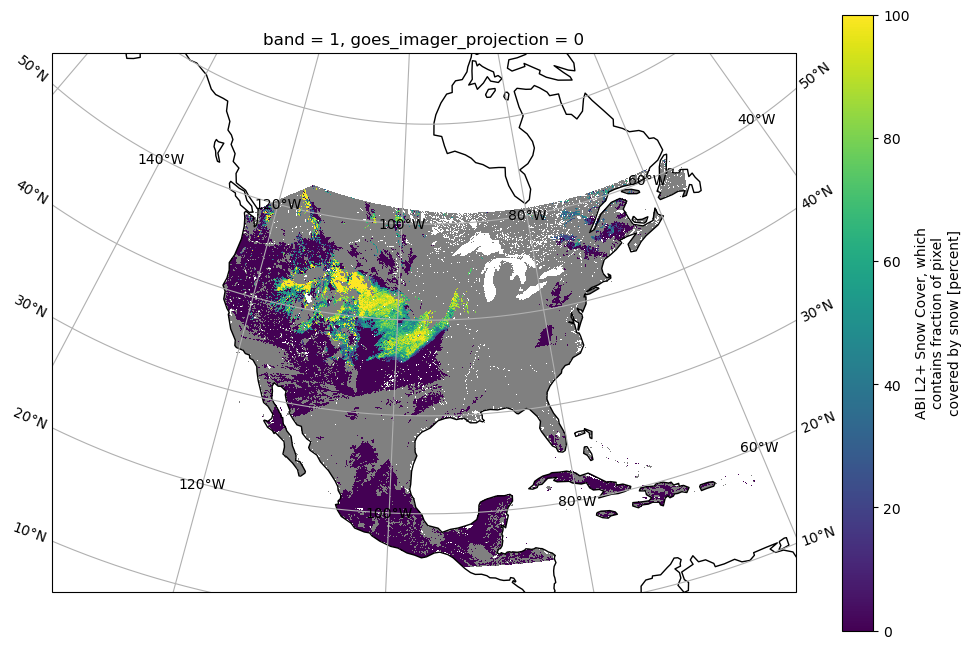

In [8]:
map_proj = ccrs.Geostationary(
    central_longitude=ds.goes_imager_projection.attrs["longitude_of_projection_origin"],
    satellite_height=ds.goes_imager_projection.attrs["perspective_point_height"],
    false_easting=ds.goes_imager_projection.attrs["false_easting"],
    false_northing=ds.goes_imager_projection.attrs["false_northing"],
    sweep_axis=ds.goes_imager_projection.attrs["sweep_angle_axis"],
)
newproj = ccrs.LambertConformal()

mask = (ds.DQF == 0)
clouds = (ds.DQF == masks["cloud"])

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": newproj})

p = ds.FSC.where(mask).plot(ax=ax, transform=map_proj)
clouds.where(clouds).plot(ax=ax, transform=map_proj, add_colorbar=False, cmap="gray");

p.axes.coastlines(resolution='110m')
p.axes.gridlines(draw_labels=True);